In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1042 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(2000*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.21s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


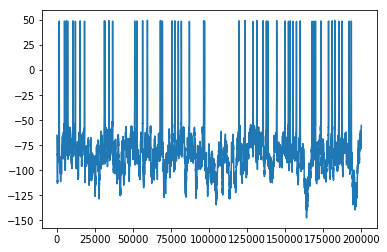

In [7]:
voltage = mon.v[0]/mV
plot(voltage);

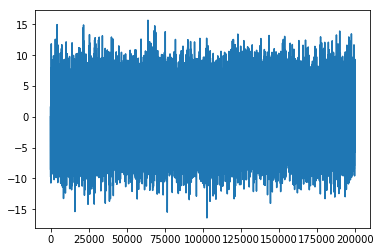

In [8]:
inp_cur = mon.I[0]/nA
plot(inp_cur);

In [9]:
out_spikes = [spike_mon.spike_trains()[0]/ms]
out_spikes

[array([  15.03,   49.61,   62.86,   70.12,  104.93,  121.23,  152.52,
         181.16,  312.13,  316.4 ,  341.32,  365.72,  511.02,  525.85,
         562.89,  594.37,  679.75,  685.64,  692.72,  754.89,  774.24,
         797.62,  817.53,  870.33,  964.08,  969.64, 1196.64, 1235.36,
        1287.33, 1313.7 , 1355.1 , 1376.36, 1386.29, 1443.98, 1498.83,
        1521.44, 1532.75, 1551.32, 1573.81, 1598.75, 1676.63, 1688.17,
        1698.73, 1735.01, 1784.51, 1808.58, 1825.34, 1851.77, 1874.09,
        1920.23, 1934.42])]

## IF

In [10]:
I = TimedArray(inp_cur*nA, dt=dt)

In [11]:
R = 76*Mohm
tau = 12.44*ms
taut = 97.64*ms
a = 0.21
alpha = 7.2*mV

model = '''
        dV/dt = (R*I(t)- V)/tau :volt
        dVt/dt = (a*V - Vt) / taut :volt
        '''

threshold = 'V > Vt'
reset = '''
V = 0*mV
Vt = Vt + alpha
'''

In [12]:
start_scope()
neuron = NeuronGroup(1, model=model,
                     threshold=threshold,
                     reset=reset,
                     refractory=1.4*ms,
                     method='exponential_euler')
trace = StateMonitor(neuron, 'V', record=0)
spike_mon = SpikeMonitor(neuron)

In [13]:
run(200*ms)

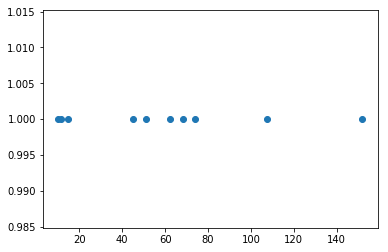

In [14]:
dd = spike_mon.spike_trains()[0]/ms
scatter(dd, np.ones_like(dd));

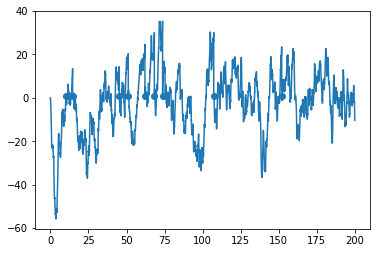

In [15]:
plot(np.arange(0, len(trace.V.transpose()/mV)*0.01, 0.01), trace.V.transpose()/mV);
scatter(dd, np.ones_like(dd));

## Model Fitting

In [50]:
tau = 12.44*ms
taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau :volt
        dvt/dt = (a*v - vt) / taut :volt
        alpha : volt (constant)
        a : 1 (constant)
        R : ohm (constant)
        '''
reset = '''
v = 0*mV
vt = vt + alpha
'''

In [72]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=300*ms)

In [73]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=[inp_cur] * nA, output=out_spikes,
                     n_samples=30,
                     threshold='v > vt',
                     reset=reset,
                     refractory=1.4*ms,
                     param_init={'v': -65*mV},
                     )

In [74]:
result_dict, error = fitter.fit(n_rounds=40,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[5,10]*mV,
                                a = [0, 1],
                                R = [0, 100]*Mohm                              
                               )

Round 0: fit (0.6513832431479027, 38125679.18415175, 0.007071687386595953) with error: 0.007765482430595938
Round 1: fit (0.6513832431479027, 38125679.18415175, 0.007071687386595953) with error: 0.007765482430595938
Round 2: fit (0.6513832431479027, 38125679.18415175, 0.007071687386595953) with error: 0.007765482430595938
Round 3: fit (0.6513832431479027, 38125679.18415175, 0.007071687386595953) with error: 0.007765482430595938
Round 4: fit (0.7838710956793338, 42315126.77415594, 0.007916765448232192) with error: 0.0014418917619917204
Round 5: fit (0.7838710956793338, 42315126.77415594, 0.007916765448232192) with error: 0.0014418917619917204
Round 6: fit (0.7595920353260164, 44573140.1018406, 0.008282963995300317) with error: 0.0014418917619917204
Round 7: fit (0.6224257020008996, 50011247.33260862, 0.008929910757036981) with error: 0.0014418917619917204
Round 8: fit (0.6456568852094096, 42151563.5791397, 0.00766577609494146) with error: 0.0014418917619917204
Round 9: fit (0.6456568852

In [75]:
result_dict

{'a': 0.8776723310544057,
 'R': 29269638.379706714,
 'alpha': 0.005784273186834829}

In [76]:
error

0.0012496395270594762

In [77]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

spike times: [array([  31.99,   33.39,   35.77,   49.97,   65.66,   71.5 ,  153.01,
        268.36,  289.84,  311.86,  315.98,  433.44,  451.84,  510.38,
        514.67,  562.83,  594.88,  678.71,  680.57,  687.36,  754.39,
        775.05,  823.31,  870.26,  955.15,  964.44,  969.22, 1063.4 ,
       1106.61, 1147.52, 1184.95, 1196.69, 1201.28, 1236.01, 1289.27,
       1314.86, 1355.85, 1385.28, 1444.04, 1498.56, 1529.93, 1551.21,
       1595.21, 1675.14, 1681.97, 1693.58, 1783.08, 1808.21, 1824.98,
       1874.5 , 1933.36, 1992.65])]


In [78]:
print(len(out_spikes[0]))
print(len(spikes[0]))

51
52


In [79]:
fits = fitter.generate(params=None, output_var='v',)

In [80]:
rcParams["scatter.marker"] = "|"

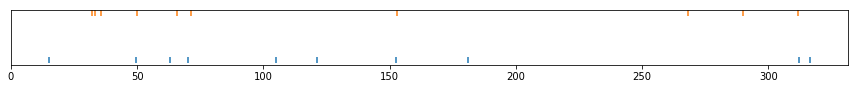

In [81]:
d=10

plt.figure(figsize=(15,1))

yticks(np.arange(0, 1, step=1))
scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

In [82]:
abs(error - 1)

0.9987503604729405